<h1><b>About GStore</b></h1>
In this case study, we’re challenged to analyze a Google Merchandise Store (also known as GStore, where Google swag is sold) customer dataset to predict revenue per customer. Hopefully, the outcome will be more actionable operational changes and a better use of marketing budgets for those companies who choose to use data analysis on top of GA data.
About Google Analytics Customer Revenue Prediction Dataset

<b>Data Source:-</b>  https://www.kaggle.com/c/ga-customer-revenue-prediction/data

Each row in the dataset is one visit to the store. We are predicting the natural log of the sum of all transactions per user.


The data fields in the given files are
<ol>
    <li>fullVisitorId- A unique identifier for each user of the Google Merchandise Store.</li>
    <li>channelGrouping - The channel via which the user came to the Store.</li>
    <li>date - The date on which the user visited the Store.</li>
<li>device - The specifications for the device used to access the Store.</li>
<li>geoNetwork - This section contains information about the geography of the user.</li>
<li>sessionId - A unique identifier for this visit to the store.</li>
<li>socialEngagementType - Engagement type, either "Socially Engaged" or "Not Socially Engaged".</li>
<li>totals - This section contains aggregate values across the session.</li>
<li>trafficSource - This section contains information about the Traffic Source from which the session originated.</li>
<li>visitId - An identifier for this session. This is part of the value usually stored as the _utmb cookie. This is only unique to the user. For a completely unique ID, you should use a combination of fullVisitorId and visitId.</li>
<li>visitNumber - The session number for this user. If this is the first session, then this is set to 1.</li>
    <li>visitStartTime - The timestamp (expressed as POSIX time).</li>
</ol>
Also it is important to note that some of the fields are in json format.
<h2> <b> Objectives</b> </h2>
Our task is to build an algorithm that predicts the natural log of the sum of all transactions per user.
Submissions are scored on the Root Mean Squared Error (RMSE)..

In [1]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


/kaggle/input/ga-customer-revenue-prediction/sample_submission_v2.csv
/kaggle/input/ga-customer-revenue-prediction/train_v2.csv
/kaggle/input/ga-customer-revenue-prediction/test_v2.csv
/kaggle/input/ga-customer-revenue-prediction/sample_submission.csv
/kaggle/input/ga-customer-revenue-prediction/test.csv
/kaggle/input/ga-customer-revenue-prediction/train.csv


In [3]:
import pandas as pd
train_data=pd.read_csv('/kaggle/input/ga-customer-revenue-prediction/train.csv')
train_data.head()

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning:

Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.



,channelGrouping,date,device,fullVisitorId,geoNetwork,sessionId,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1131660440785968503,"{""continent"": ""Asia"", ""subContinent"": ""Western...",1131660440785968503_1472830385,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472830385,1,1472830385
1,Organic Search,20160902,"{""browser"": ""Firefox"", ""browserVersion"": ""not ...",377306020877927890,"{""continent"": ""Oceania"", ""subContinent"": ""Aust...",377306020877927890_1472880147,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472880147,1,1472880147
2,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3895546263509774583,"{""continent"": ""Europe"", ""subContinent"": ""South...",3895546263509774583_1472865386,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472865386,1,1472865386
3,Organic Search,20160902,"{""browser"": ""UC Browser"", ""browserVersion"": ""n...",4763447161404445595,"{""continent"": ""Asia"", ""subContinent"": ""Southea...",4763447161404445595_1472881213,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472881213,1,1472881213
4,Organic Search,20160902,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",27294437909732085,"{""continent"": ""Europe"", ""subContinent"": ""North...",27294437909732085_1472822600,Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""1"", ""pageviews"": ""1"",...","{""campaign"": ""(not set)"", ""source"": ""google"", ...",1472822600,2,1472822600


In [4]:
import pandas as pd
train_data=pd.read_csv('/kaggle/input/ga-customer-revenue-prediction/train.csv')
test_data=pd.read_csv('/kaggle/input/ga-customer-revenue-prediction/test.csv')


In [5]:
def load_df(csv_path='/kaggle/input/ga-customer-revenue-prediction/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, # Important!!
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [column+'.'+subcolumn for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    return df


In [6]:
%%time
train_df = load_df()
test_df=load_df('/kaggle/input/ga-customer-revenue-prediction/test.csv')

CPU times: user 4min 36s, sys: 13 s, total: 4min 49s
Wall time: 4min 50s


In [7]:
train_df.head(2)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
test_df.head(2)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.newVisits,totals.bounces,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Singapore,(not set),(not set),(not set),not available in demo dataset,myrepublic.com.sg,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,4,NaN,NaN,(not set),google,organic,(not provided),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Aragon,(not set),Zaragoza,not available in demo dataset,rima-tde.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,5,5,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h2>EDA</h2>

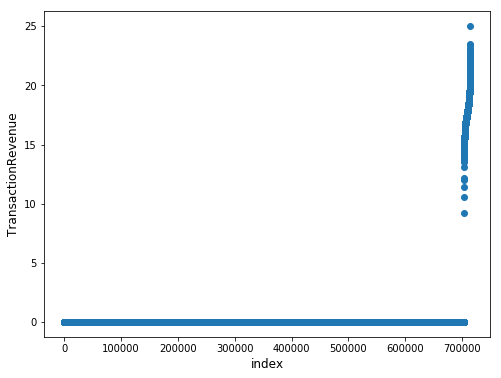

In [9]:
train_df["totals.transactionRevenue"] = train_df["totals.transactionRevenue"].astype('float')
gdf = train_df.groupby("fullVisitorId")["totals.transactionRevenue"].sum().reset_index()

plt.figure(figsize=(8,6))
plt.scatter(range(gdf.shape[0]), np.sort(np.log1p(gdf["totals.transactionRevenue"].values)))
plt.xlabel('index', fontsize=12)
plt.ylabel('TransactionRevenue', fontsize=12)
plt.show()

<b> Observations </b> : -  We can see that only few percentage of customers is generating revenue. We can say that there is 80/20 rules is applied on that only 20% of customers are generating 80% of revenue.  

<h3> <b> Missing Values</b> </h3>

In [10]:
for col in train_df.columns:
    nullrow=train_df[col].isnull().sum()
    notrow=train_df[col].notnull().sum()
    percentage=(nullrow*100)/(nullrow+notrow)
    if percentage > 30:
        print("Column is",col,nullrow,notrow,percentage)
    

Column is totals.bounces 453023 450630 50.132407019065944
Column is totals.transactionRevenue 892138 11515 98.72572768529513
Column is trafficSource.keyword 502929 400724 55.655102124377386
Column is trafficSource.isTrueDirect 629648 274005 69.67807333124551
Column is trafficSource.referralPath 572712 330941 63.37742474157669
Column is trafficSource.adwordsClickInfo.page 882193 21460 97.62519462669852
Column is trafficSource.adwordsClickInfo.slot 882193 21460 97.62519462669852
Column is trafficSource.adwordsClickInfo.gclId 882092 21561 97.61401777009537
Column is trafficSource.adwordsClickInfo.adNetworkType 882193 21460 97.62519462669852
Column is trafficSource.adwordsClickInfo.isVideoAd 882193 21460 97.62519462669852
Column is trafficSource.adContent 892707 10946 98.78869433289105
Column is trafficSource.campaignCode 903652 1 99.99988933805344


In [11]:
drop_col_missing=["totals.bounces","trafficSource.adContent","trafficSource.adwordsClickInfo.adNetworkType","trafficSource.adwordsClickInfo.gclId",
"trafficSource.adwordsClickInfo.isVideoAd","trafficSource.adwordsClickInfo.page","trafficSource.adwordsClickInfo.slot","trafficSource.campaignCode","trafficSource.isTrueDirect","trafficSource.keyword","trafficSource.referralPath"]

train_df.drop(drop_col_missing,axis=1,inplace=True)
train_df.shape

(903653, 44)

In [12]:
test_df.head(2)

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.newVisits,totals.bounces,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Singapore,(not set),(not set),(not set),not available in demo dataset,myrepublic.com.sg,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,4,NaN,NaN,(not set),google,organic,(not provided),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Aragon,(not set),Zaragoza,not available in demo dataset,rima-tde.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,5,5,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
drop_col_missing=["totals.bounces","trafficSource.adContent","trafficSource.adwordsClickInfo.adNetworkType","trafficSource.adwordsClickInfo.gclId",
"trafficSource.adwordsClickInfo.isVideoAd","trafficSource.adwordsClickInfo.page","trafficSource.adwordsClickInfo.slot","trafficSource.isTrueDirect","trafficSource.keyword","trafficSource.referralPath"]

test_df.drop(drop_col_missing,axis=1,inplace=True)
test_df.shape

(804684, 43)

In [14]:
# We will takeoff all columns where we have a unique value
# It is useful because this columns don't give us none information
clean_consts = [col for col in train_df.columns if train_df[col].nunique() == 1]


# this function drop all constant columns, inplacing the data 
train_df.drop(clean_consts, axis=1, inplace=True) 
test_df.drop(clean_consts,axis=1,inplace=True)
# printing the total of columns dropped and the name of columns 
print("This useful action will drop: ", len(clean_consts), "columns")
print("All dropped columns: \n", clean_consts)
train_df.shape

This useful action will drop:  20 columns
All dropped columns: 
 ['socialEngagementType', 'device.browserVersion', 'device.browserSize', 'device.operatingSystemVersion', 'device.mobileDeviceBranding', 'device.mobileDeviceModel', 'device.mobileInputSelector', 'device.mobileDeviceInfo', 'device.mobileDeviceMarketingName', 'device.flashVersion', 'device.language', 'device.screenColors', 'device.screenResolution', 'geoNetwork.cityId', 'geoNetwork.latitude', 'geoNetwork.longitude', 'geoNetwork.networkLocation', 'totals.visits', 'totals.newVisits', 'trafficSource.adwordsClickInfo.criteriaParameters']


(903653, 24)

In [15]:
# Columns not in test data

print("Variables not in test but in train : ", set(train_df.columns).difference(set(test_df.columns)))
#train_df.drop('trafficSource.campaignCode',axis=1,inplace=True)

Variables not in test but in train :  {'totals.transactionRevenue'}


In [16]:
for col in train_df.columns:
    train_df[col] = train_df[col].fillna(train_df[col].value_counts().index[0])
for col in test_df.columns:
    test_df[col] = test_df[col].fillna(test_df[col].value_counts().index[0])


In [20]:
def FillingNaValues(df):    # fillna numeric feature
    df['totals.pageviews']=df['totals.pageviews'].fillna(1).astype(int) #filling NA's with 1
    
    df["totals.transactionRevenue"] = df["totals.transactionRevenue"].fillna(0.0).astype(float) #filling NA with zero

    df.loc[df['geoNetwork.city'] == "(not set)", 'geoNetwork.city'] = np.nan
    df['geoNetwork.city'].fillna("NaN", inplace=True)

    return df #return the transformed dataframe


In [18]:
FillingNaValues(train_df)
train_df.shape

(903653, 24)

In [21]:
FillingNaValues(test_df)
test_df.shape

(804684, 23)

In [22]:
train_df.head(2)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,16990000.0,(not set),google,organic
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,16990000.0,(not set),google,organic


<h2> <b> Univariate Analaysis </b> </h2>

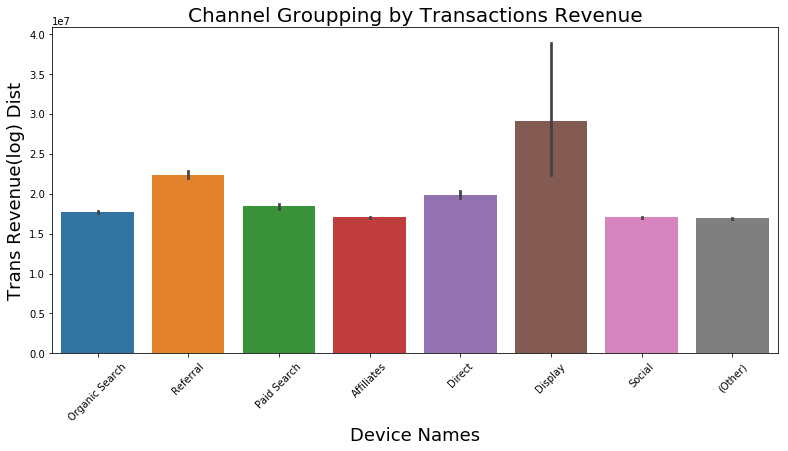

In [23]:
#Channel Groupping and Transaction

plt.figure(figsize=(13,6)) #figure size

#It's another way to plot our data. using a variable that contains the plot parameters
g1 = sns.barplot(x='channelGrouping', y='totals.transactionRevenue', 
                   data=train_df[(train_df['channelGrouping'].isin((train_df['channelGrouping'].value_counts()[:10].index.values))) &
                                  train_df['totals.transactionRevenue'] > 0])
g1.set_title('Channel Groupping by Transactions Revenue', fontsize=20) # title and fontsize
g1.set_xticklabels(g1.get_xticklabels(),rotation=45) # It's the way to rotate the xticks when we use variable to our graphs
g1.set_xlabel('Device Names', fontsize=18) # Xlabel
g1.set_ylabel('Trans Revenue(log) Dist', fontsize=18) #Ylabel

plt.show()

<b> Observations </b> : -  We can comparing Channel Groupping with the transaction revenue to know that is this column is giving to us any useful information. we observed that It is giving clear idea about the customer who came from display channel that is generating more revenue.

In [24]:
# EDA Date

import datetime

def scatter_plot(cnt_srs, color):
    trace = go.Scatter(
        x=cnt_srs.index[::-1],
        y=cnt_srs.values[::-1],
        showlegend=False,
        marker=dict(
            color=color,
        ),
    )
    return trace

train_df['date'] = train_df['date'].apply(lambda x: datetime.date(int(str(x)[:4]), int(str(x)[4:6]), int(str(x)[6:])))
cnt_srs = train_df.groupby('date')['totals.transactionRevenue'].agg(['size', 'count'])
cnt_srs.columns = ["count", "count of non-zero revenue"]
cnt_srs = cnt_srs.sort_index()
#cnt_srs.index = cnt_srs.index.astype('str')
trace1 = scatter_plot(cnt_srs["count"], 'red')
trace2 = scatter_plot(cnt_srs["count of non-zero revenue"], 'blue')

fig = tools.make_subplots(rows=2, cols=1, vertical_spacing=0.08,
                          subplot_titles=["Date - Count", "Date - Non-zero Revenue count"])
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 2, 1)
fig['layout'].update(height=800, width=800, paper_bgcolor='rgb(233,233,233)', title="Date Plots")
py.iplot(fig, filename='date-plots')


/opt/conda/lib/python3.6/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



<b> Observations </b> : -  Almost their is similarity between the counts and Non-zero revenue counts.Only frequency changes in  from start of Nav 2016 to start of Jan 2017

In [25]:

def horizontal_bar_chart(cnt_srs, color):
    trace = go.Bar(
        y=cnt_srs.index[::-1],
        x=cnt_srs.values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

# Device Browser
cnt_srs = train_df.groupby('device.browser')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(50, 171, 96, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(50, 171, 96, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(50, 171, 96, 0.6)')

# Device Category
cnt_srs = train_df.groupby('device.deviceCategory')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(71, 58, 131, 0.8)')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(71, 58, 131, 0.8)')
trace6 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(71, 58, 131, 0.8)')

# Operating system
cnt_srs = train_df.groupby('device.operatingSystem')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(246, 78, 139, 0.6)')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10),'rgba(246, 78, 139, 0.6)')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10),'rgba(246, 78, 139, 0.6)')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.04, 
                          subplot_titles=["Device Browser - Count", "Device Browser - Non-zero Revenue Count", "Device Browser - Mean Revenue",
                                          "Device Category - Count",  "Device Category - Non-zero Revenue Count", "Device Category - Mean Revenue", 
                                          "Device OS - Count", "Device OS - Non-zero Revenue Count", "Device OS - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Device Plots")
py.iplot(fig, filename='device-plots')

<b> Observations </b> : -
<ul>
    <li> We can see that the person who is generating revenue or not mostly using chrome browser</li>
    <li> And most  of the person is using it through desktop as compare to mobile </li>
    <li> Very large amount of peoples are using it through windows OS then Macintosh </li>
</ul>

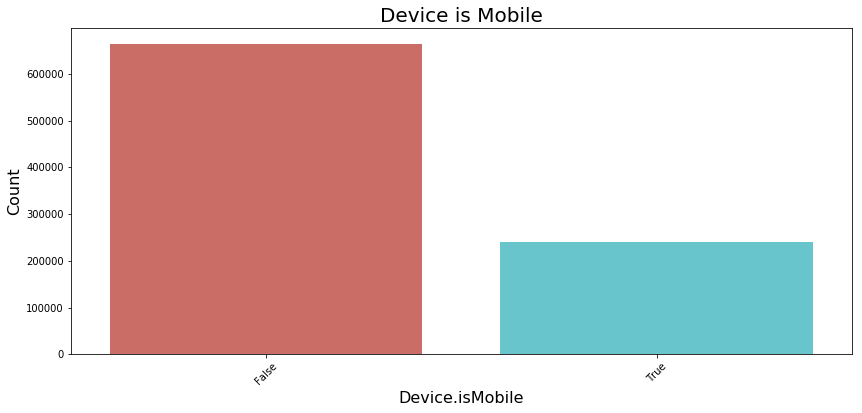

In [26]:
#Device isMobile


# seting the graph size
plt.figure(figsize=(14,6))

# Let explore the browser used by users
sns.countplot(train_df[train_df['device.isMobile']\
                       .isin(train_df['device.isMobile']\
                             .value_counts()[:10].index.values)]['device.isMobile'], palette="hls") # It's a module to count the category's
plt.title("Device is Mobile", fontsize=20) # Adding Title and seting the size
plt.xlabel("Device.isMobile", fontsize=16) # Adding x label and seting the size
plt.ylabel("Count", fontsize=16) # Adding y label and seting the size
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels

plt.show() #use plt.show to render the graph that we did above


<b> Observations </b> : - We can is see that there is no in the options of Device.isMobile it means that there is less amount of customers who are using Mobile

In [27]:
# EDA geoNetwork

# Continent
cnt_srs = train_df.groupby('geoNetwork.continent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'rgba(58, 71, 80, 0.6)')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'rgba(58, 71, 80, 0.6)')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'rgba(58, 71, 80, 0.6)')

# Sub-continent
cnt_srs = train_df.groupby('geoNetwork.subContinent')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'orange')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'orange')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'orange')

# Network domain
cnt_srs = train_df.groupby('geoNetwork.networkDomain')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace7 = horizontal_bar_chart(cnt_srs["count"].head(10), 'blue')
trace8 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'blue')
trace9 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'blue')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Continent - Count", "Continent - Non-zero Revenue Count", "Continent - Mean Revenue",
                                          "Sub Continent - Count",  "Sub Continent - Non-zero Revenue Count", "Sub Continent - Mean Revenue",
                                          "Network Domain - Count", "Network Domain - Non-zero Revenue Count", "Network Domain - Mean Revenue"])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)
fig.append_trace(trace7, 3, 1)
fig.append_trace(trace8, 3, 2)
fig.append_trace(trace9, 3, 3)

fig['layout'].update(height=1500, width=1200, paper_bgcolor='rgb(233,233,233)', title="Geography Plots")
py.iplot(fig, filename='geo-plots')


<b> Observations </b> : -  
<ul>
    <li> Through the continent we can see that most of revenue generating customers or customers who are not generating revenue belongs to Americas </li>
    <li> Through the sub-continent we can see that Northern America is playing vital role </li>
    <li> Mostly not-set Network Domain is used a lot means most of customer their network domain information is not complete </li>
 </ul>
    

In [28]:
#EDA Traffice Source

# Continent
cnt_srs = train_df.groupby('trafficSource.source')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace1 = horizontal_bar_chart(cnt_srs["count"].head(10), 'green')
trace2 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"].head(10), 'green')
trace3 = horizontal_bar_chart(cnt_srs["mean"].head(10), 'green')

# Sub-continent
cnt_srs = train_df.groupby('trafficSource.medium')['totals.transactionRevenue'].agg(['size', 'count', 'mean'])
cnt_srs.columns = ["count", "count of non-zero revenue", "mean"]
cnt_srs = cnt_srs.sort_values(by="count", ascending=False)
trace4 = horizontal_bar_chart(cnt_srs["count"], 'purple')
trace5 = horizontal_bar_chart(cnt_srs["count of non-zero revenue"], 'purple')
trace6 = horizontal_bar_chart(cnt_srs["mean"], 'purple')

# Creating two subplots
fig = tools.make_subplots(rows=2, cols=3, vertical_spacing=0.08, horizontal_spacing=0.15, 
                          subplot_titles=["Traffic Source - Count", "Traffic Source - Non-zero Revenue Count", "Traffic Source - Mean Revenue",
                                          "Traffic Source Medium - Count",  "Traffic Source Medium - Non-zero Revenue Count", "Traffic Source Medium - Mean Revenue"
                                          ])

fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 2)
fig.append_trace(trace3, 1, 3)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 2)
fig.append_trace(trace6, 2, 3)

fig['layout'].update(height=1000, width=1200, paper_bgcolor='rgb(233,233,233)', title="Traffic Source Plots")
py.iplot(fig, filename='traffic-source-plots')

<b> Observations </b> : -  
 We can see that most of customer there traffic source is google and medium is Organic search.

In [29]:
train_df['date']=train_data['date']

In [30]:
from datetime import datetime

# This function is to extract date features
def date_process(df):
    df["date"] = pd.to_datetime(df["date"], format="%Y%m%d") # seting the column as pandas datetime
    df["_weekday"] = df['date'].dt.weekday #extracting week day
    df["_day"] = df['date'].dt.day # extracting day
    df["_month"] = df['date'].dt.month # extracting day
    df["_year"] = df['date'].dt.year # extracting day
    df['_visitHour'] = (df['visitStartTime'].apply(lambda x: str(datetime.fromtimestamp(x).hour))).astype(int)
    
    return df #returning the df after the transformations
#printing the first 2 rows of our dataset


In [31]:

train_df = date_process(train_df) #calling the function that we created above
train_df['date']=train_data['date']
test_df = date_process(test_df) #calling the function that we created above
test_df['date']=test_data['date']


In [32]:
train_df.head(2)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,_weekday,_day,_month,_year,_visitHour
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,1,1,16990000.0,(not set),google,organic,4,2,9,2016,15
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,1,1,16990000.0,(not set),google,organic,4,2,9,2016,5


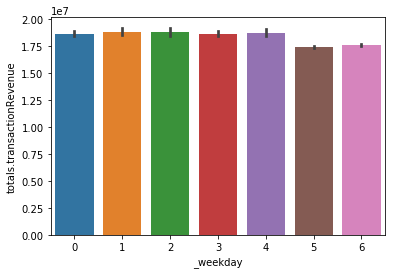

In [33]:
sns.barplot(x=train_df['_weekday'], y=train_df['totals.transactionRevenue'], data=train_df)


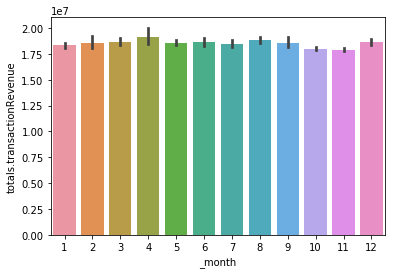

In [34]:
sns.barplot(x=train_df['_month'], y=train_df['totals.transactionRevenue'], data=train_df)


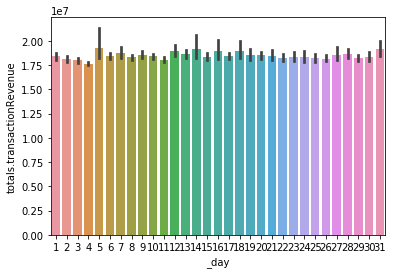

In [35]:
sns.barplot(x=train_df['_day'], y=train_df['totals.transactionRevenue'], data=train_df)


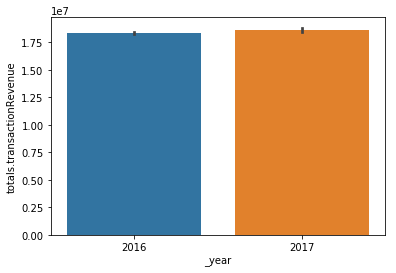

In [36]:
sns.barplot(x=train_df['_year'], y=train_df['totals.transactionRevenue'], data=train_df)


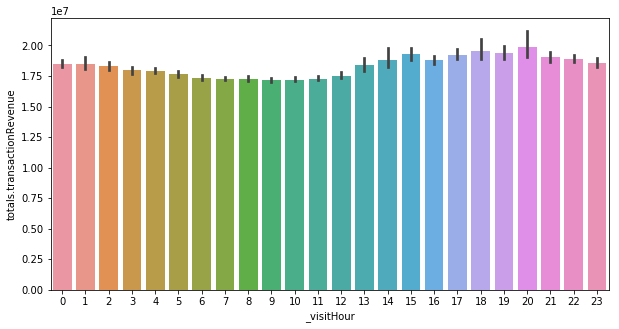

In [37]:
plt.figure(figsize=(10,5))
sns.barplot(x=train_df['_visitHour'], y=train_df['totals.transactionRevenue'], data=train_df)

<b> Observations </b> : -  
<ul>
    <li> We can see that in _weekday there is less sales on Weekends like Sat, Sun. </li>
    <li> There is not much variation according to the months. Every months the overall performance in sales is similar. </li>
    <li> In Days there is less sales in first 3 days of every months </li>
    <li> We can see that on hourly basis there is no much sales is happen in between 6 to 11 afterwords sales is increasing slightly. </li>
</ul>

<b>Bivariate Analysis</b>

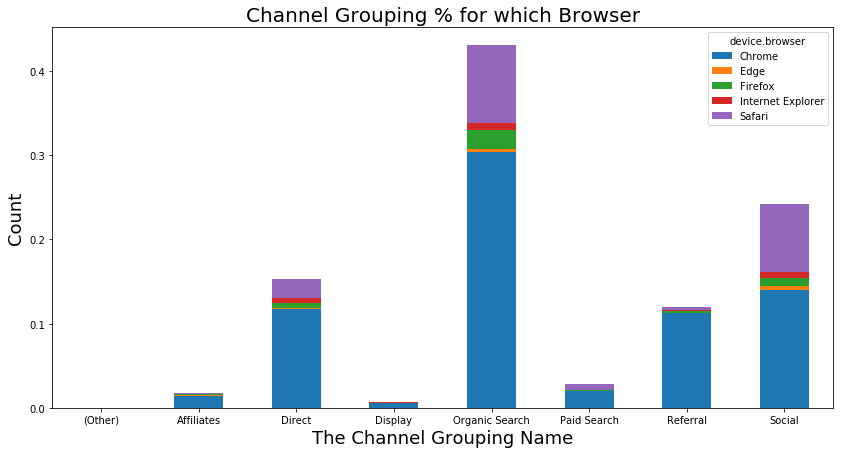

In [38]:
# Channel groupping and Browsers

## I will use the crosstab to explore two categorical values

# At index I will use set my variable that I want analyse and cross by another
crosstab_eda = pd.crosstab(index=train_df['channelGrouping'], normalize=True,
                           # at this line, I am using the isin to select just the top 5 of browsers
                           columns=train_df[train_df['device.browser'].isin(train_df['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])
# Ploting the crosstab that we did above
crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                 figsize=(14,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("Channel Grouping % for which Browser", fontsize=20) # seting the title size
plt.xlabel("The Channel Grouping Name", fontsize=18) # seting the x label size
plt.ylabel("Count", fontsize=18) # seting the y label size
plt.xticks(rotation=0)
plt.show() # rendering


<b> Observations </b> : -  We can see that the large numbers of customers who is from Organic Search are using a lot chrome as device browser. And Also in the other change their is most of part of customers is using chrome as browser.

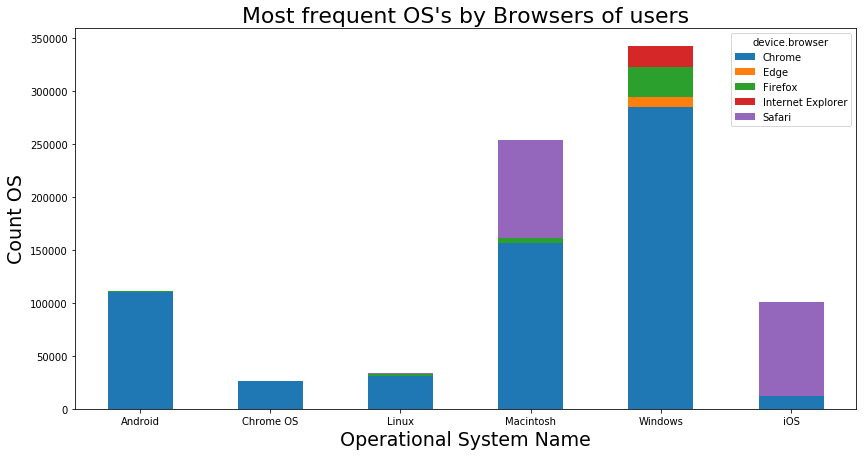

In [39]:
#  OS and Browsers

# At index I will use isin to substitute the loop and get just the values with more than 1%
crosstab_eda = pd.crosstab(index=train_df[train_df['device.operatingSystem']\
                                          .isin(train_df['device.operatingSystem']\
                                                .value_counts()[:6].index.values)]['device.operatingSystem'], 
                           
                           # at this line, I am using the isin to select just the top 5 of browsers
                           columns=train_df[train_df['device.browser'].isin(train_df['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])
# Ploting the crosstab that we did above
crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                 figsize=(14,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("Most frequent OS's by Browsers of users", fontsize=22) # adjusting title and fontsize
plt.xlabel("Operational System Name", fontsize=19) # adjusting x label and fontsize
plt.ylabel("Count OS", fontsize=19) # adjusting y label and fontsize
plt.xticks(rotation=0) # Adjust the xticks, rotating the labels

plt.show() # rendering

<b> Observations </b> : -  Most of Windows users are using chrome as device browser. In the Macintosh users their is chrome users are more as compare with Safari users.

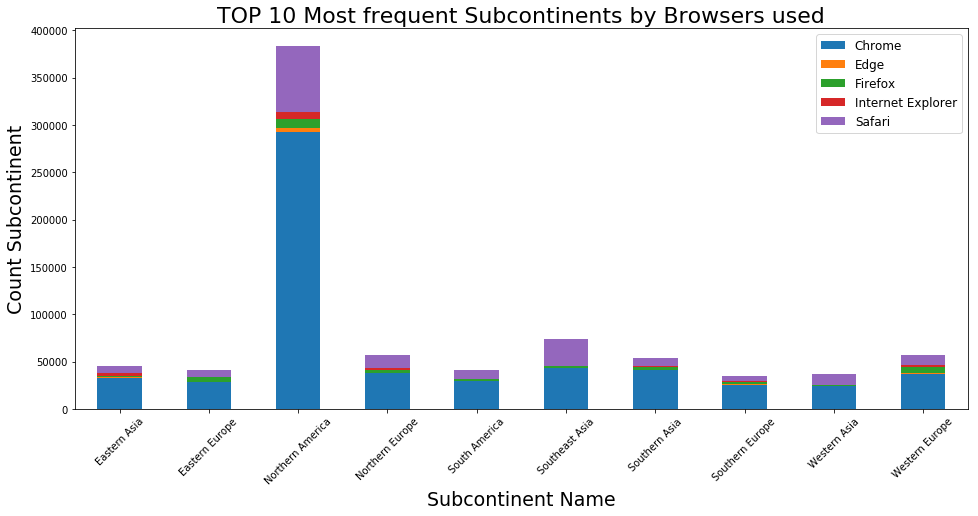

In [40]:
#Subcotinent And Browsers

# I will use the crosstab to explore two categorical values

# At index I will use isin to substitute the loop and get just the values with more than 1%
crosstab_eda = pd.crosstab(index=train_df[train_df['geoNetwork.subContinent']\
                                          .isin(train_df['geoNetwork.subContinent']\
                                                .value_counts()[:10].index.values)]['geoNetwork.subContinent'], 
                           
                           # at this line, I am using the isin to select just the top 5 of browsers
                           columns=train_df[train_df['device.browser'].isin(train_df['device.browser']\
                                                                            .value_counts()[:5].index.values)]['device.browser'])
# Ploting the crosstab that we did above
crosstab_eda.plot(kind="bar",    # select the bar to plot the count of categoricals
                 figsize=(16,7), # adjusting the size of graphs
                 stacked=True)   # code to unstack 
plt.title("TOP 10 Most frequent Subcontinents by Browsers used", fontsize=22) # adjusting title and fontsize
plt.xlabel("Subcontinent Name", fontsize=19) # adjusting x label and fontsize
plt.ylabel("Count Subcontinent", fontsize=19) # adjusting y label and fontsize
plt.xticks(rotation=45) # Adjust the xticks, rotating the labels
plt.legend(loc=1, prop={'size': 12}) # to 

plt.show() # rendering

<b> Observations </b> : -  Most of Northern America's customers are using chrome as device browser. there is huge amount of people who are using chrome as browsers.


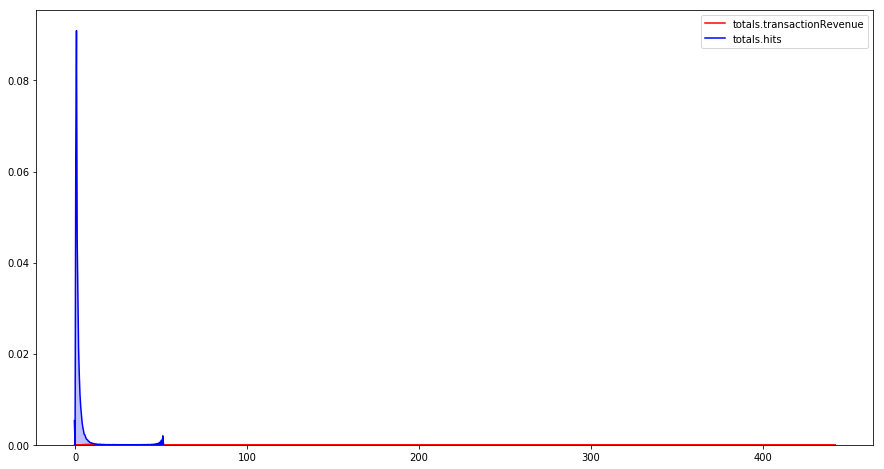

In [41]:
from sklearn.preprocessing import StandardScaler

train_df[['totals.transactionRevenue', 'totals.hits']] = StandardScaler().fit_transform(train_df[['totals.transactionRevenue', 'totals.hits']])

import seaborn as sns
#df = sns.load_dataset('iris')
from matplotlib import pyplot
plt.figure(figsize=(15,8))

# plot of 2 variables
p1=sns.kdeplot(train_df['totals.transactionRevenue'], shade=True, color="r")
p1=sns.kdeplot(train_df['totals.hits'], shade=True, color="b")
plt.show()


In [42]:
train_df.head(2)

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,_weekday,_day,_month,_year,_visitHour
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,-0.373029,1,-0.028464,(not set),google,organic,4,2,9,2016,15
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,-0.373029,1,-0.028464,(not set),google,organic,4,2,9,2016,5


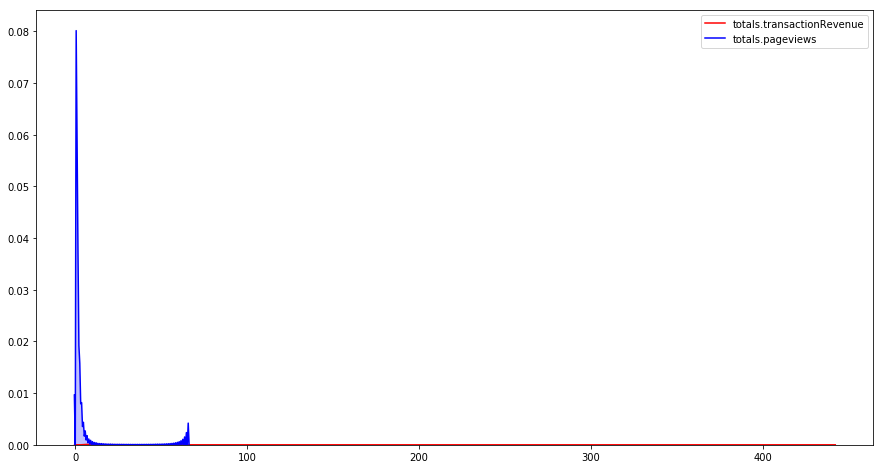

In [43]:
from sklearn.preprocessing import StandardScaler

train_df[['totals.transactionRevenue', 'totals.pageviews']] = StandardScaler().fit_transform(train_df[['totals.transactionRevenue', 'totals.pageviews']])

import seaborn as sns
#df = sns.load_dataset('iris')
from matplotlib import pyplot
plt.figure(figsize=(15,8))

# plot of 2 variables
p1=sns.kdeplot(train_df['totals.transactionRevenue'], shade=True, color="r")
p1=sns.kdeplot(train_df['totals.pageviews'], shade=True, color="b")
plt.show()


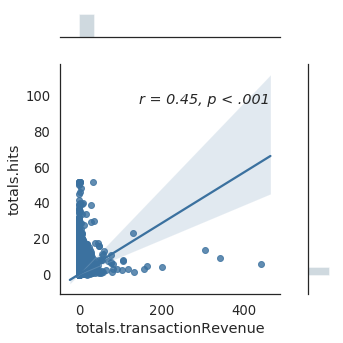

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
sns.set(style='white', font_scale=1.2)

g = sns.JointGrid(data=train_df, x='totals.transactionRevenue', y='totals.hits',height=5)
g = g.plot_joint(sns.regplot, color="xkcd:muted blue")
g = g.plot_marginals(sns.distplot, kde=False, bins=12, color="xkcd:bluey grey")
g.ax_joint.text(145, 95, 'r = 0.45, p < .001', fontstyle='italic')
plt.tight_layout()


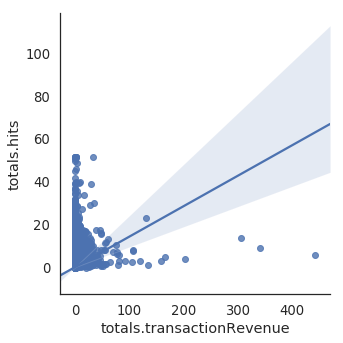

In [45]:
import seaborn as sns

sns.lmplot(x='totals.transactionRevenue', y='totals.hits', data=train_df)


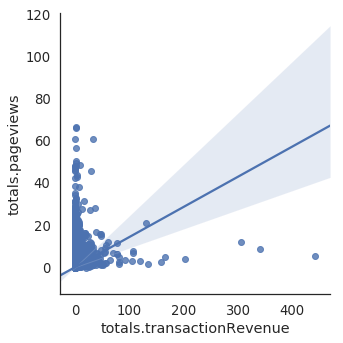

In [46]:
sns.lmplot(x='totals.transactionRevenue', y='totals.pageviews', data=train_df)


In [47]:
train_df.head()

,channelGrouping,date,fullVisitorId,sessionId,visitId,visitNumber,visitStartTime,device.browser,device.operatingSystem,device.isMobile,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.networkDomain,totals.hits,totals.pageviews,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,_weekday,_day,_month,_year,_visitHour
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,1472830385,1,1472830385,Chrome,Windows,False,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,ttnet.com.tr,-0.373029,-0.405619,-0.028464,(not set),google,organic,4,2,9,2016,15
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,1472880147,1,1472880147,Firefox,Macintosh,False,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,-0.373029,-0.405619,-0.028464,(not set),google,organic,4,2,9,2016,5
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,1472865386,1,1472865386,Chrome,Windows,False,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,unknown.unknown,-0.373029,-0.405619,-0.028464,(not set),google,organic,4,2,9,2016,1
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,1472881213,1,1472881213,UC Browser,Linux,False,desktop,Asia,Southeast Asia,Indonesia,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,-0.373029,-0.405619,-0.028464,(not set),google,organic,4,2,9,2016,5
4,Organic Search,20160902,27294437909732085,27294437909732085_1472822600,1472822600,2,1472822600,Chrome,Android,True,mobile,Europe,Northern Europe,United Kingdom,not available in demo dataset,not available in demo dataset,not available in demo dataset,unknown.unknown,-0.373029,-0.405619,-0.028464,(not set),google,organic,4,2,9,2016,13


In [48]:
train_df['device.isMobile'].value_counts()

False    664530
True     239123
Name: device.isMobile, dtype: int64

In [49]:
def ConisMobile(df):
    for i in range(len(df)):
        if df['device.isMobile'][i]==True:
            df['device.isMobile'][i]=1
        elif df['device.isMobile'][i]==False:
            df['device.isMobile'][i]=0

In [50]:
ConisMobile(train_df)
ConisMobile(test_df)

In [51]:
train_df.columns

Index(['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId',
       'visitNumber', 'visitStartTime', 'device.browser',
       'device.operatingSystem', 'device.isMobile', 'device.deviceCategory',
       'geoNetwork.continent', 'geoNetwork.subContinent', 'geoNetwork.country',
       'geoNetwork.region', 'geoNetwork.metro', 'geoNetwork.city',
       'geoNetwork.networkDomain', 'totals.hits', 'totals.pageviews',
       'totals.transactionRevenue', 'trafficSource.campaign',
       'trafficSource.source', 'trafficSource.medium', '_weekday', '_day',
       '_month', '_year', '_visitHour'],
      dtype='object')

In [52]:
# Impute 0 for missing target values
train_df["totals.transactionRevenue"].fillna(0, inplace=True)
train_y = train_df["totals.transactionRevenue"].values
train_id = train_df["fullVisitorId"].values
test_id = test_df["fullVisitorId"].values

# label encode the categorical variables and convert the numerical variables to float
cat_cols = ["channelGrouping", "device.browser","device.isMobile",
            "device.deviceCategory", "device.operatingSystem", 
            "geoNetwork.city", "geoNetwork.continent", 
            "geoNetwork.country", "geoNetwork.metro",
            "geoNetwork.networkDomain", "geoNetwork.region", 
            "geoNetwork.subContinent","trafficSource.campaign",
             "trafficSource.medium","trafficSource.source"]
for col in cat_cols:
    #print(col)
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))


num_cols = ["totals.hits", "totals.pageviews", "visitNumber", "visitStartTime",'_weekday','_day','_month','_year','_visitHour']
    
for col in num_cols:
    train_df[col] = train_df[col].astype(float)
    test_df[col] = test_df[col].astype(float)

# Split the train dataset into development and valid based on time 
dev_df = train_df[train_df['date']<=20170531]
val_df = train_df[train_df['date']>20170531]
dev_y = np.log1p(dev_df["totals.transactionRevenue"].values)
val_y = np.log1p(val_df["totals.transactionRevenue"].values)

dev_X = dev_df[cat_cols + num_cols] 
val_X = val_df[cat_cols + num_cols] 
test_X = test_df[cat_cols + num_cols] 

In [53]:
dev_X.head(2)

,channelGrouping,device.browser,device.isMobile,device.deviceCategory,device.operatingSystem,geoNetwork.city,geoNetwork.continent,geoNetwork.country,geoNetwork.metro,geoNetwork.networkDomain,geoNetwork.region,geoNetwork.subContinent,trafficSource.campaign,trafficSource.medium,trafficSource.source,totals.hits,totals.pageviews,visitNumber,visitStartTime,_weekday,_day,_month,_year,_visitHour
0,4,35,0,0,20,377,3,210,0,37454,193,21,4,5,208,-0.373029,-0.405619,1.0,1.472830e+09,4.0,2.0,9.0,2016.0,15.0
1,4,43,0,0,7,955,5,12,122,10098,482,1,4,5,208,-0.373029,-0.405619,1.0,1.472880e+09,4.0,2.0,9.0,2016.0,5.0


In [54]:
# custom function to run light gbm model
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMClassifier
from sklearn import metrics
def run_lgb(train_X, train_y, val_X, val_y, test_X):
    params = {
        "objective" : "regression",
        "metric" : "rmse", 
        "num_leaves" : 30,
        "min_child_samples" : 100,
        "learning_rate" : 0.1,
        "bagging_fraction" : 0.7,
        "feature_fraction" : 0.5,
        "bagging_frequency" : 5,
        "bagging_seed" : 2018,
        "verbosity" : -1
    }
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = lgb.Dataset(val_X, label=val_y)
    model = lgb.train(params, lgtrain, 1000, valid_sets=[lgval], early_stopping_rounds=100, verbose_eval=100)
    
    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    return pred_test_y, model, pred_val_y

# Training the model #
pred_test, model, pred_val = run_lgb(dev_X, dev_y, val_X, val_y, test_X)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's rmse: 0.107893
[200]	valid_0's rmse: 0.107735
Early stopping, best iteration is:
[170]	valid_0's rmse: 0.107683


In [56]:
sub_df = pd.DataFrame({"fullVisitorId":test_id})
pred_test[pred_test<0] = 0
sub_df["PredictedLogRevenue"] = np.expm1(pred_test)
sub_df = sub_df.groupby("fullVisitorId")["PredictedLogRevenue"].sum().reset_index()
sub_df.columns = ["fullVisitorId", "PredictedLogRevenue"]
sub_df["PredictedLogRevenue"] = np.log1p(sub_df["PredictedLogRevenue"])
sub_df.to_csv("baseline_lgb_1.csv", index=False)

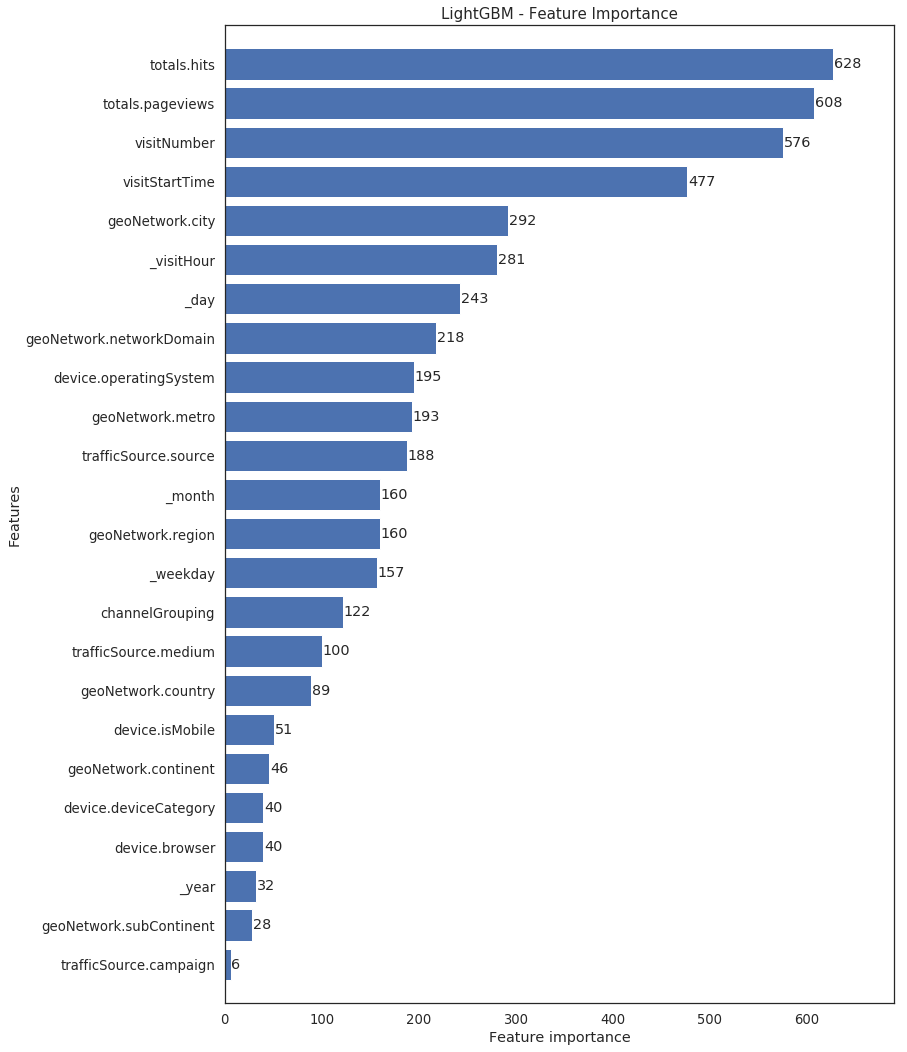

In [55]:
fig, ax = plt.subplots(figsize=(12,18))
lgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
ax.grid(False)
plt.title("LightGBM - Feature Importance", fontsize=15)
plt.show()